<table width="100%">
  <tr>
    <td>
      <h1 style="text-align: left; font-size:300%;">Homework 2 - Time Series forecasting challenge</h1>
      <table align="left">
        <tr>
          <td style="text-align: left;">Bottazzi Daniele</td>
          <td style="text-align: left;"><a href="mailto:nouhaila.benhdidou@mail.polimi.it">daniele.bottazzi@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Resta Sara</td>
          <td style="text-align: left;"><a href="mailto:daniele.bottazzi@mail.polimi.it">sara.resta@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Saldarini Gaia</td>
          <td style="text-align: left;"><a href="mailto:annalisa.imperiali@mail.polimi.it">gaia.saldarini@mail.polimi.it</a></td>
        </tr>
      </table>
    </td>
    <td width="20%">
      <div style="text-align: right">
          <br>
        <b style="font-size: 120%;">AN2DL course</b><br>
        <b>a.y. 2023-2024</b>
          <br><br>
        prof. M. Matteucci<br>
        prof. G. Boracchi<br>
      </div>
    </td>
  </tr>
</table>

# Predictions on Trend and Seasonality with Attention

 Link to dowload the `filtered_datasets` used in this Notebook: [link](https://drive.google.com/drive/folders/1FuVLBucfEEDN3pPuNTSgjwv6_3Rstn_4?usp=sharing). A Cython implementation of the STL decomposition function, adapted from \verb|statsmodels|, can be downloaded at this [link](https://drive.google.com/drive/folders/1IwnELTHiVrctOTquShoOCbZyNh2TWV6n?usp=sharing).

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.tsa.seasonal import STL
from tensorflow.keras import backend as K

### Load and preprocess the dataset

In [ ]:
window = 198
stride = 11

In [ ]:
telescope = 18
direct_telescope = telescope

In [ ]:
# Load dataset
unique_series = np.load('filtered_datasets/filtered_series_02.npy')
unique_valid_periods = np.load('filtered_datasets/filtered_valid_periods_02.npy')
unique_categories = np.load('filtered_datasets/filtered_categories_02.npy')

In [ ]:
# Remove padding from unique seqies
valid_series = np.array([row[start:end+1] for row, (start, end) in zip(unique_series, unique_valid_periods)])
valid_series.shape

(47048,)

In [ ]:
# Split into train_validation and test sets
series_train_val, series_test, categories_train_val, categories_test = train_test_split(valid_series, unique_categories, random_state=seed, test_size=0.1)

# Print shapes of the datasets
print(f"series_train_val shape: {series_train_val.shape}, categories_train_val shape: {categories_train_val.shape}")
print(f"series_test shape: {series_test.shape}, categories_test shape: {categories_test.shape}\n")

# See if stratification was succesful
print(np.unique(categories_train_val, return_counts = True))
print(np.unique(categories_test, return_counts = True))

series_train_val shape: (42343,), categories_train_val shape: (42343,)
series_test shape: (4705,), categories_test shape: (4705,)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'), array([5065, 9701, 8765, 8785, 9796,  231]))
(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'), array([ 611, 1047,  996,  991, 1037,   23]))


In [ ]:
def extract_trend_seasonality(time_series, period=12):

    stl = STL(time_series, period=period)
    result = stl.fit()

    # Obtain the detrended series and the trend components
    seasonality = result.seasonal
    trend = result.trend
    residuals = result.resid

    return seasonality, trend, residuals, result

In [ ]:
def replicate_array_reverse(original_array, desired_length, period=12):
    original_length = len(original_array)
    period_compliant_array = original_array[(original_length % period):]
    period_compliant_length = len(period_compliant_array)
    replication_factor = desired_length // period_compliant_length
    remainder = desired_length % period_compliant_length

    replicated_array = list(period_compliant_array[::-1]) * replication_factor + list(period_compliant_array[::-1][:remainder])

    return np.array(replicated_array[::-1])

In [ ]:
def build_sequences_univariate(series_array, window=66, stride=22, telescope=18):
    """
    Build univariate time series sequences for training and testing.

    Parameters:
        - series_array (list of arrays): List of univariate time series.
        - window (int): Size of the input sequence.
        - stride (int): Stride for selecting sequences.
        - telescope (int): Size of the future sequence.

    Returns:
        - sequences_s (numpy array): Trend component of the input sequences.
        - sequences_t (numpy array): Sum of trend and seasonality components of the input sequences.
        - future_sequences_s (numpy array): Trend component of the future sequences.
        - future_sequences_t (numpy array): Sum of trend and seasonality components of the future sequences.
    """
    assert window % stride == 0

    sequences_s = []
    sequences_t = []
    sequences_r = []
    future_sequences_s = []
    future_sequences_t = []
    future_sequences_r = []

    for series in series_array:
        series_len = len(series)
        diff = series_len - window - telescope
        s = series

        if diff <= 0:
            # Replicate the series backward the number of times needed to cover padding_len
            s = replicate_array_reverse(s, window + telescope)
            assert len(s) == (window + telescope)

        for idx in np.arange(len(s) - window - telescope, -1, -stride):
            series_xy = s[idx:idx + window + telescope]
            series_x = series_xy[0:window]
            series_y = series_xy[window:window + telescope]

            series_x_s, series_x_t, series_x_r, result_x = extract_trend_seasonality(series_x)
            series_y_s, series_y_t, series_y_r, result_y = extract_trend_seasonality(series_y)

            sequences_s.append(series_x_s)
            sequences_t.append(series_x_t)
            sequences_r.append(series_x_r)

            future_sequences_s.append(series_y_s)
            future_sequences_t.append(series_y_t)
            future_sequences_r.append(series_y_r)

    sequences_s = np.array(sequences_s)
    sequences_t = np.array(sequences_t)
    sequences_r = np.array(sequences_r)

    future_sequences_s = np.array(future_sequences_s)
    future_sequences_t = np.array(future_sequences_t)
    future_sequences_r = np.array(future_sequences_r)

    return sequences_s, sequences_t + sequences_r, future_sequences_s, future_sequences_t + future_sequences_r


In [ ]:
X_train_val_seasonality, X_train_val_trend_res, y_train_val_seasonality, y_train_val_trend_res = build_sequences_univariate(series_train_val, window = window, stride = stride, telescope = direct_telescope)

In [ ]:
print("X_train_val_seasonality shape:", X_train_val_seasonality.shape)
print("X_train_val_trend_res shape:", X_train_val_trend_res.shape)
print("y_train_val_seasonality shape:", y_train_val_seasonality.shape)
print("y_train_val_trend_res shape:", y_train_val_trend_res.shape)

X_train_val_seasonality shape: (208175, 198)
X_train_val_trend_res shape: (208175, 198)
y_train_val_seasonality shape: (208175, 18)
y_train_val_trend_res shape: (208175, 18)


In [ ]:
X_test_seasonality, X_test_trend_res, y_test_seasonality, y_test_trend_res = build_sequences_univariate(series_test, window = window, stride = stride, telescope = direct_telescope)

In [ ]:
print("X_test_seasonality shape:", X_test_seasonality.shape)
print("X_test_trend_res shape:", X_test_trend_res.shape)
print("y_test_seasonality shape:", y_test_seasonality.shape)
print("y_test_trend_res shape:", y_test_trend_res.shape)

X_test_seasonality shape: (23420, 198)
X_test_trend_res shape: (23420, 198)
y_test_seasonality shape: (23420, 18)
y_test_trend_res shape: (23420, 18)


In [ ]:
# Split train_validation sequences into train and validation sets
X_train_seasonality, X_val_seasonality, X_train_trend_res, X_val_trend_res, y_train_seasonality, y_val_seasonality, y_train_trend_res, y_val_trend_res = train_test_split(X_train_val_seasonality, X_train_val_trend_res, y_train_val_seasonality, y_train_val_trend_res, shuffle=True, random_state=seed, test_size=0.2)

In [ ]:
print("X_train_seasonality shape:", X_train_seasonality.shape)
print("X_val_seasonality shape:", X_val_seasonality.shape)
print("X_train_trend_res shape:", X_train_trend_res.shape)
print("X_val_trend_res shape:", X_val_trend_res.shape)

print("\ny_train_seasonality shape:", y_train_seasonality.shape)
print("y_val_seasonality shape:", y_val_seasonality.shape)
print("y_train_trend_res shape:", y_train_trend_res.shape)
print("y_val_trend_res shape:", y_val_trend_res.shape)

X_train_seasonality shape: (166540, 198)
X_val_seasonality shape: (41635, 198)
X_train_trend_res shape: (166540, 198)
X_val_trend_res shape: (41635, 198)

y_train_seasonality shape: (166540, 18)
y_val_seasonality shape: (41635, 18)
y_train_trend_res shape: (166540, 18)
y_val_trend_res shape: (41635, 18)


In [ ]:
# SAVE
folder_name = "stl_seq_no_pad_198"
os.makedirs(folder_name, exist_ok=True)

# Save test data
np.save(os.path.join(folder_name, 'X_test_seasonality.npy'), X_test_seasonality)
np.save(os.path.join(folder_name, 'X_test_trend_res.npy'), X_test_trend_res)
np.save(os.path.join(folder_name, 'y_test_seasonality.npy'), y_test_seasonality)
np.save(os.path.join(folder_name, 'y_test_trend_res.npy'), y_test_trend_res)

# Save train and validation data
np.save(os.path.join(folder_name, 'X_train_seasonality.npy'), X_train_seasonality)
np.save(os.path.join(folder_name, 'X_val_seasonality.npy'), X_val_seasonality)
np.save(os.path.join(folder_name, 'X_train_trend_res.npy'), X_train_trend_res)
np.save(os.path.join(folder_name, 'X_val_trend_res.npy'), X_val_trend_res)

np.save(os.path.join(folder_name, 'y_train_seasonality.npy'), y_train_seasonality)
np.save(os.path.join(folder_name, 'y_val_seasonality.npy'), y_val_seasonality)
np.save(os.path.join(folder_name, 'y_train_trend_res.npy'), y_train_trend_res)
np.save(os.path.join(folder_name, 'y_val_trend_res.npy'), y_val_trend_res)

In [ ]:
# LOAD
folder_name = "stl_seq_no_pad_198"

# Load test data
X_test_seasonality = np.load(os.path.join(folder_name, 'X_test_seasonality.npy'))
X_test_trend_res = np.load(os.path.join(folder_name, 'X_test_trend_res.npy'))
y_test_seasonality = np.load(os.path.join(folder_name, 'y_test_seasonality.npy'))
y_test_trend_res = np.load(os.path.join(folder_name, 'y_test_trend_res.npy'))

# Load train and validation data
X_train_seasonality = np.load(os.path.join(folder_name, 'X_train_seasonality.npy'))
X_val_seasonality = np.load(os.path.join(folder_name, 'X_val_seasonality.npy'))
X_train_trend_res = np.load(os.path.join(folder_name, 'X_train_trend_res.npy'))
X_val_trend_res = np.load(os.path.join(folder_name, 'X_val_trend_res.npy'))

y_train_seasonality = np.load(os.path.join(folder_name, 'y_train_seasonality.npy'))
y_val_seasonality = np.load(os.path.join(folder_name, 'y_val_seasonality.npy'))
y_train_trend_res = np.load(os.path.join(folder_name, 'y_train_trend_res.npy'))
y_val_trend_res = np.load(os.path.join(folder_name, 'y_val_trend_res.npy'))

In [ ]:
X_train = X_train_seasonality + X_train_trend_res
X_val = X_val_seasonality + X_val_trend_res
X_test = X_test_seasonality + X_test_trend_res

y_train = y_train_seasonality + y_train_trend_res
y_val = y_val_seasonality + y_val_trend_res
y_test = y_test_seasonality + y_test_trend_res

In [ ]:
# Expand dimensions
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
X_train_trend_res = np.expand_dims(X_train_trend_res, axis=-1)
X_val_trend_res = np.expand_dims(X_val_trend_res, axis=-1)
X_test_trend_res = np.expand_dims(X_test_trend_res, axis=-1)

y_train_trend_res = np.expand_dims(y_train_trend_res, axis=-1)
y_val_trend_res = np.expand_dims(y_val_trend_res, axis=-1)
y_test_trend_res = np.expand_dims(y_test_trend_res, axis=-1)

In [ ]:
X_train_seasonality = np.expand_dims(X_train_seasonality, axis=-1)
X_val_seasonality = np.expand_dims(X_val_seasonality, axis=-1)
X_test_seasonality = np.expand_dims(X_test_seasonality, axis=-1)

y_train_seasonality = np.expand_dims(y_train_seasonality, axis=-1)
y_val_seasonality = np.expand_dims(y_val_seasonality, axis=-1)
y_test_seasonality = np.expand_dims(y_test_seasonality, axis=-1)

In [ ]:
X_train_seasonality = X_train_seasonality[:, -36:]
X_val_seasonality = X_val_seasonality[:, -36:]
X_test_seasonality = X_test_seasonality[:, -36:]

In [ ]:
input_shape  = X_train.shape[1:]
output_shape = y_train.shape[1:]

trend_input_shape  = X_train_trend_res.shape[1:]
trend_output_shape = y_train_trend_res.shape[1:]

seasonality_input_shape  = X_train_seasonality.shape[1:]
seasonality_output_shape = y_train_seasonality.shape[1:]

In [ ]:
batch_size = 64
epochs = 200

## Model

In [ ]:
# Model for Trend
x_trend = tfkl.Input(shape=(trend_input_shape))
x = tfkl.Bidirectional(tfkl.LSTM(8, return_sequences=True, name='bidirectional_lstm'))(x_trend)
x = tfkl.MultiHeadAttention(num_heads=2, key_dim=1)(x, x, x)
x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)
x = tfkl.Conv1D(trend_output_shape[1], 3, padding='same', name='output_layer')(x)
x = tfkl.Conv1D(filters=1, kernel_size=3, strides=1, input_shape=input_shape, padding='valid')(x)
x = tfkl.MaxPooling1D(pool_size=2, strides=2)(x)
x = tfkl.Flatten()(x)
x = tfkl.Dense(units=18, activation='linear')(x)
x_trend_output = tfkl.Reshape(target_shape=(18, 1))(x)

model_LSTM_trend = tf.keras.Model(inputs=x_trend, outputs=x_trend_output, name='model_LSTM_trend')

# Model for Seasonality
x_seasonality = tfkl.Input(shape=(seasonality_input_shape))
x = tfkl.Bidirectional(tfkl.LSTM(8, return_sequences=True, name='bidirectional_lstm'))(x_seasonality)
x = tfkl.MultiHeadAttention(num_heads=32, key_dim=1)(x, x, x)
x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)
x = tfkl.Conv1D(seasonality_output_shape[1], 3, padding='same', name='output_layer')(x)
x_seasonality_output = tfkl.Conv1D(filters=1, kernel_size=2, strides=2, input_shape=x.shape, padding='valid')(x)

model_LSTM_seasonality = tfk.Model(inputs=x_seasonality, outputs=x_seasonality_output, name='model_LSTM_seasonality')

In [ ]:
# Define input layers
input_trend = tfkl.Input(shape=trend_input_shape, name='input_1')
input_seasonality = tfkl.Input(shape=seasonality_input_shape, name='input_2')

# Separate branches for trend and seasonality
output_trend = model_LSTM_trend(input_trend)
output_seasonality = model_LSTM_seasonality(input_seasonality)

# Combine trend and seasonality branches
combined = tfkl.Add(name='add_model')([output_trend, output_seasonality])

# Create the model
model = tfk.Model(inputs=[input_trend, input_seasonality],
              outputs=[output_trend, output_seasonality, combined])

In [ ]:
# Compile the model with Mean Absolute Error loss and Adam optimizer
model.compile(loss={"model_LSTM_trend": tf.keras.losses.MeanAbsoluteError(),
                    "model_LSTM_seasonality": tf.keras.losses.MeanAbsoluteError(),
                    "add_model": tf.keras.losses.MeanAbsoluteError()},
              loss_weights=[0., 0., 1],
              optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 198, 1)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 36, 1)]              0         []                            
                                                                                                  
 model_LSTM_trend (Function  (None, 18, 1)                9233      ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 model_LSTM_seasonality (Fu  (None, 18, 1)                9460      ['input_2[0][0]']         

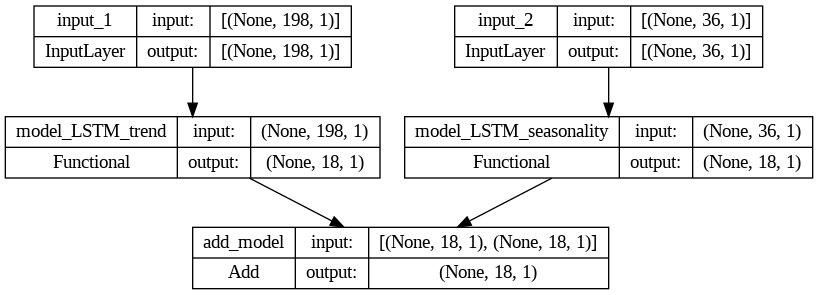

In [ ]:
tfk.utils.plot_model(model, expand_nested=False, show_shapes=True)

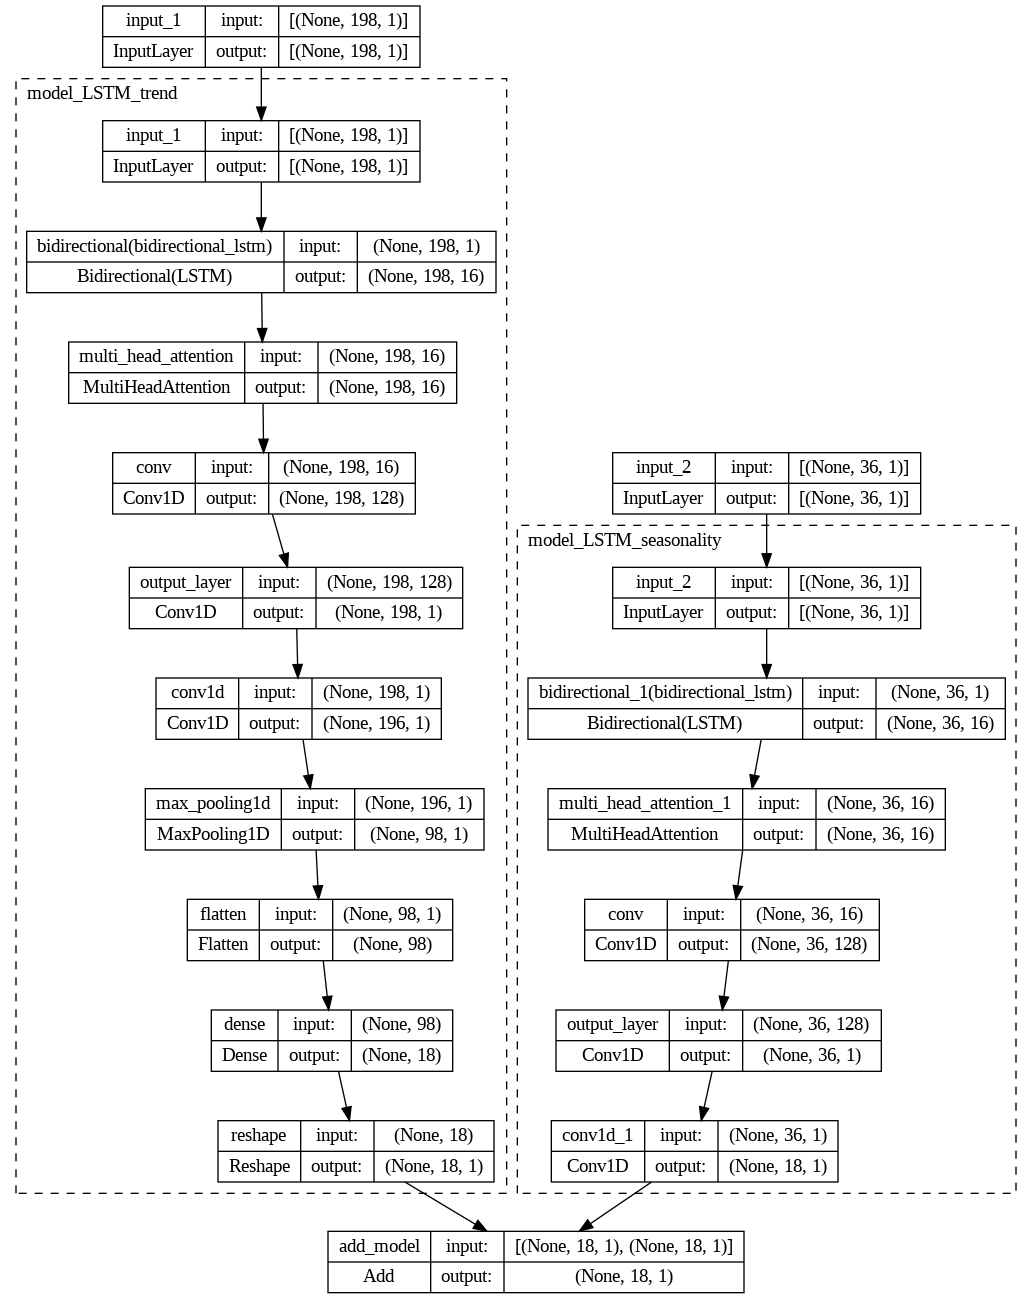

In [ ]:
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Ensure X_train_trend_res, X_train_seasonality, and X_train have the correct shapes
print(X_train_trend_res.shape)
print(X_train_seasonality.shape)
print(X_train.shape)

(166540, 198, 1)
(166540, 36, 1)
(166540, 198, 1)


In [ ]:
batch_size = 32
epochs = 200

In [ ]:
# Fit the model
history = model.fit(
    x={
        'input_1': X_train_trend_res,
        'input_2': X_train_seasonality
    },
    y=[y_train_trend_res, y_train_seasonality, y_train],  # target data
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        [X_val_trend_res, X_val_seasonality],
        [y_val_trend_res, y_val_seasonality, y_val]
    ),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_add_model_loss', mode='min', patience=10, restore_best_weights=True,min_delta=1e-4),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_add_model_loss', mode='min', patience=7, factor=0.2, min_lr=1e-5,min_delta=1e-4)
    ]
).history

Epoch 1/200
5205/5205 [==============================] - 182s 32ms/step - loss: 0.0891 - model_LSTM_trend_loss: 0.2020 - model_LSTM_seasonality_loss: 0.1940 - attention_LSTM_model_loss: 0.0891 - val_loss: 0.0766 - val_model_LSTM_trend_loss: 0.2494 - val_model_LSTM_seasonality_loss: 0.2477 - val_attention_LSTM_model_loss: 0.0766 - lr: 0.0020
Epoch 2/200
5205/5205 [==============================] - 166s 32ms/step - loss: 0.0779 - model_LSTM_trend_loss: 0.2727 - model_LSTM_seasonality_loss: 0.2702 - attention_LSTM_model_loss: 0.0779 - val_loss: 0.0780 - val_model_LSTM_trend_loss: 0.2857 - val_model_LSTM_seasonality_loss: 0.2804 - val_attention_LSTM_model_loss: 0.0780 - lr: 0.0020
Epoch 3/200
5205/5205 [==============================] - 167s 32ms/step - loss: 0.0750 - model_LSTM_trend_loss: 0.2954 - model_LSTM_seasonality_loss: 0.2941 - attention_LSTM_model_loss: 0.0750 - val_loss: 0.0762 - val_model_LSTM_trend_loss: 0.2991 - val_model_LSTM_seasonality_loss: 0.3009 - val_attention_LSTM_mod

In [ ]:
model.save('trend_seasonality_attention_replicate_001_MAE')

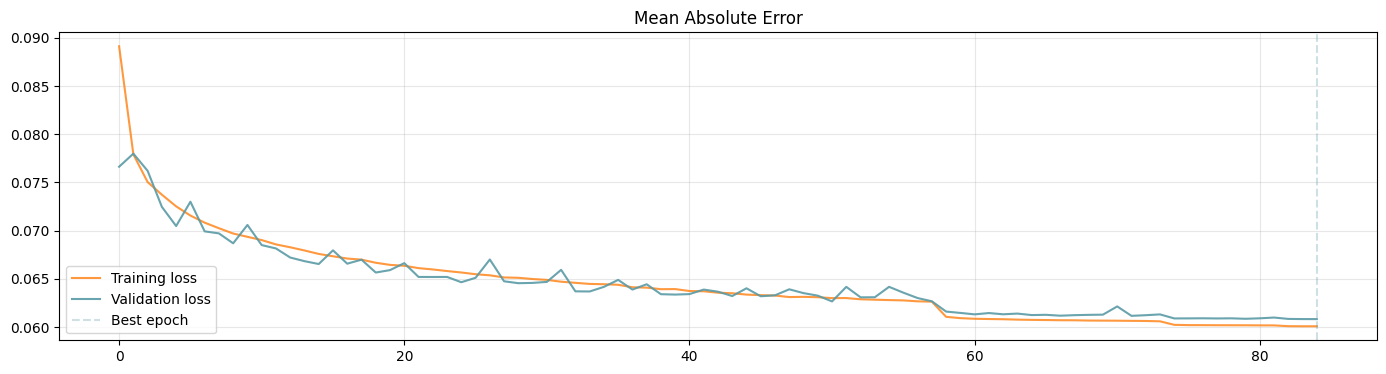

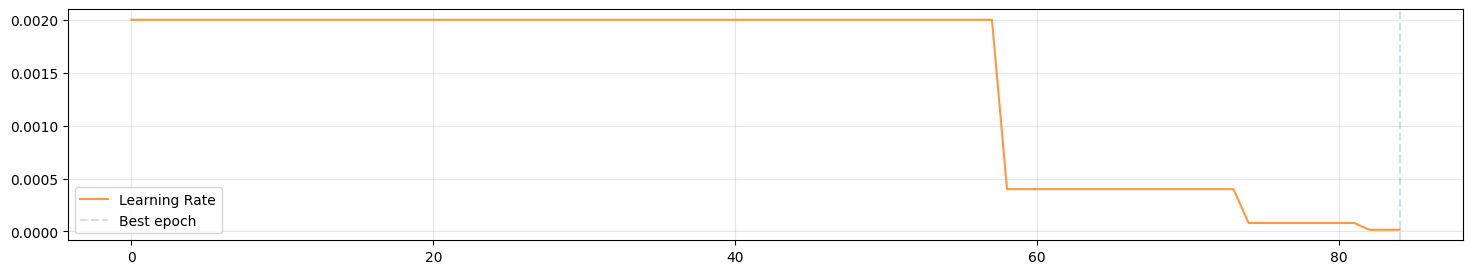

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model = tfk.models.load_model('trend_seasonality_attention_replicate_001_MAE')

In [ ]:
print("X_test_seasonality shape:", X_test_seasonality.shape)
print("X_test_trend_res shape:", X_test_trend_res.shape)
print("y_test shape:", y_test.shape)

X_test_seasonality shape: (23420, 36, 1)
X_test_trend_res shape: (23420, 198, 1)
y_test shape: (23420, 18, 1)


In [ ]:
# Predict the test set using the model
predictions = model.predict([X_test_trend_res, X_test_seasonality], verbose=0)

In [ ]:
len(predictions)

3

In [ ]:
p0 = predictions[0] # prediction of the trend

In [ ]:
p1 = predictions[1] # prediction of the seasonality

In [ ]:
p2 = predictions[2] # prediction of the complete time series

In [ ]:
predictions_9 = p2[:, 0:9]
# Print the shape of the predictions
print(f"Predictions shape: {predictions_9.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test[:, 0:9, :].flatten(), predictions_9.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test[:, 0:9, :].flatten(), predictions_9.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (23420, 9, 1)
Mean Squared Error: 0.006443271413445473
Mean Absolute Error: 0.049208659678697586


In [ ]:
# Print the shape of the predictions
print(f"Predictions shape: {p2.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), p2.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), p2.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (23420, 18, 1)
Mean Squared Error: 0.009108235128223896
Mean Absolute Error: 0.06056009232997894


In [ ]:
def inspect_univariate_prediction(X, y, pred, telescope, idx = 42):
    pred = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),y],axis=1)

    plt.figure(figsize=(20, 3))
    plt.plot(np.arange(len(X[idx])), X[idx])
    plt.plot(np.arange(len(X[idx])-1, len(X[idx]) + telescope), y[idx], color='orange')
    plt.plot(np.arange(len(X[idx])-1, len(X[idx]) + telescope), pred[idx], color='green') # forecast
    plt.ylim(0,1)
    plt.show()

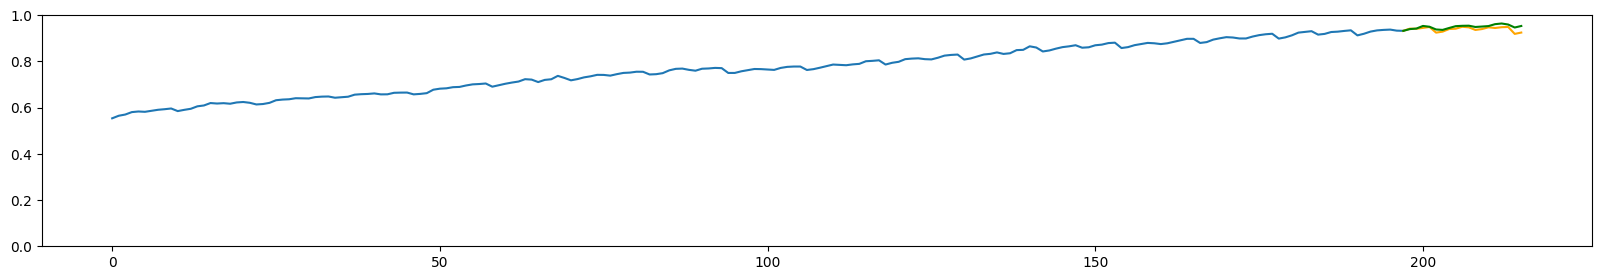

In [ ]:
inspect_univariate_prediction(X_test, y_test, p2, telescope, idx = 4312)

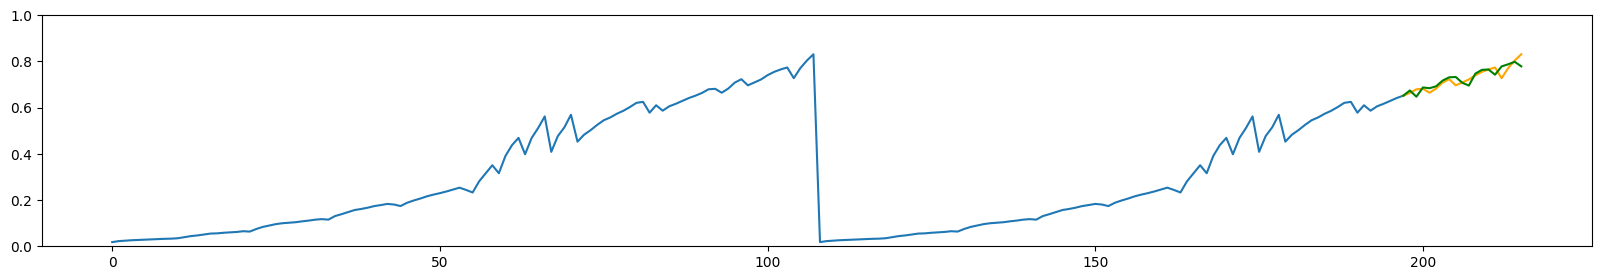

In [ ]:
inspect_univariate_prediction(X_test, y_test, p2, telescope, idx = 5)

By predicting future seasonality and trends independently, based on past observations, it provides a more explainable output. Predictions of the seasonality and of the trend are shifted for visualization purposes.

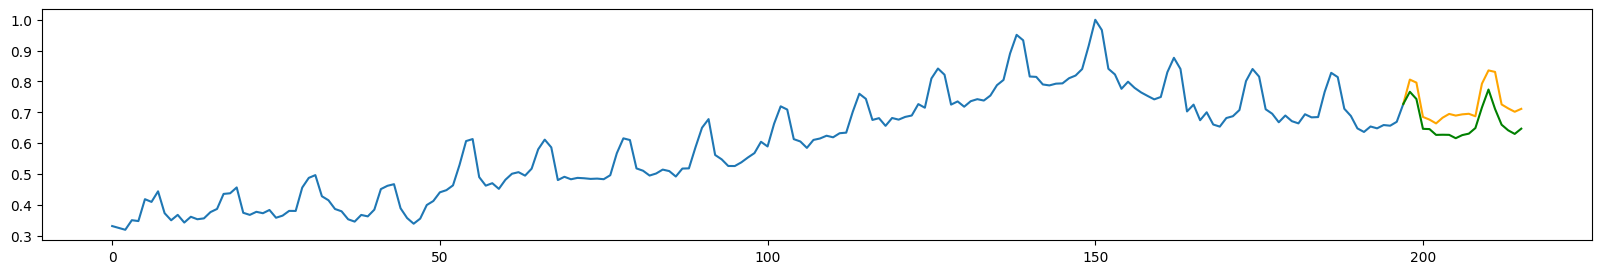

In [ ]:
inspect_univariate_prediction(X_test, y_test, p2, telescope, idx = 321)

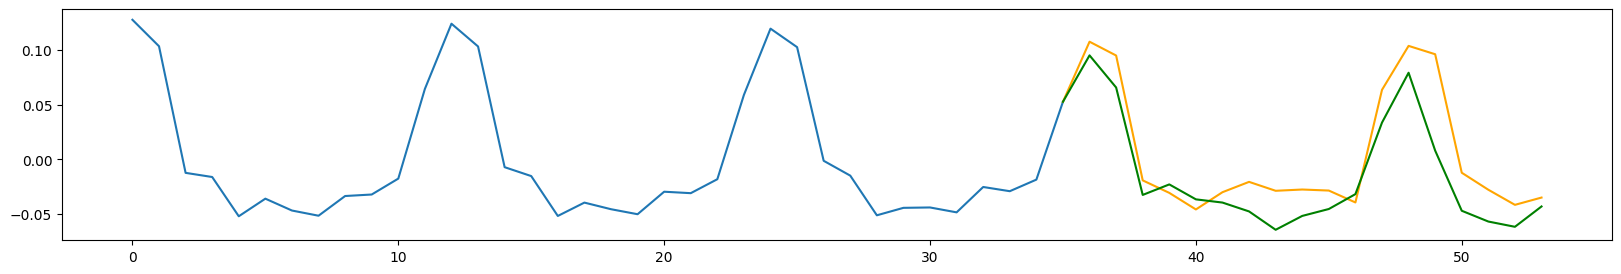

In [ ]:
inspect_univariate_prediction(X_test_seasonality, y_test_seasonality, p1 - 0.3*np.mean(p2), telescope, idx = 321)

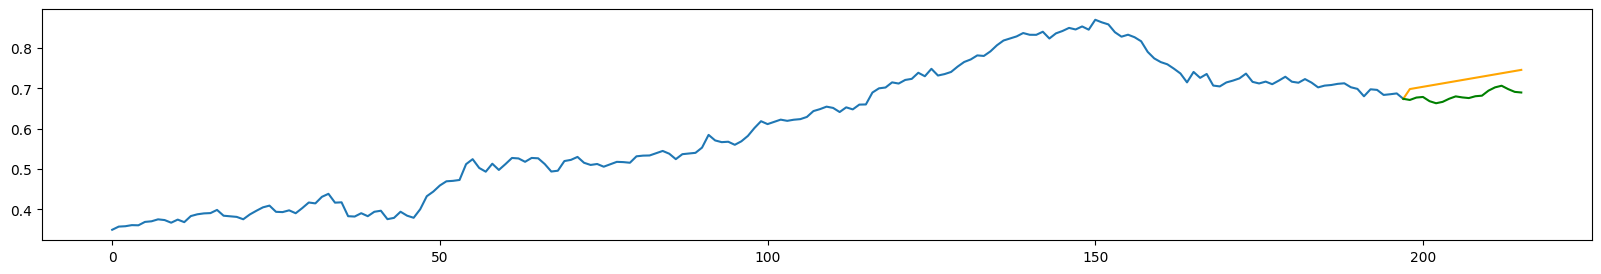

In [ ]:
inspect_univariate_prediction(X_test_trend_res, y_test_trend_res, p0 + 0.3 * np.mean(p2), telescope, idx = 321)

## `model.py`

In [ ]:
%%writefile model.py
import os

import tensorflow as tf
import numpy as np
import pandas as pd

from STL_server_friendly import STL_prova

def apply_stl(matrix, period=12):

    num_rows, num_cols = matrix.shape

    trend_matrix = np.zeros_like(matrix, dtype=float)
    seasonality_matrix = np.zeros_like(matrix, dtype=float)

    for i in range(num_rows):
        # Extract the time series
        series = matrix[i, :]

        # Apply STL decomposition
        stl = STL_prova(series, period=period)
        result = stl.fit()

        # Obtain the detrended series and trend components
        seasonality = result.seasonal
        trend = result.trend
        residual = result.resid

        # Assign the seasonalities and trends' values back to the result matrices
        trend_matrix[i, :] = trend + residual
        seasonality_matrix[i, :] = seasonality

    return trend_matrix, seasonality_matrix

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X, categories):

        trends, seasonalities = apply_stl(X[:,-198:])

        seasonalities = seasonalities[:,-36:]

        # Predict and keep only the first 9 future timestamps predictions
        predictions = self.model.predict([trends, seasonalities])

        p2 = predictions[2]

        out = p2.reshape(-1, 18)

        return out
